# 线性回归
线性回归输出是一个连续值，因此适用于回归问题。回归问题在实际中很常见，如预测房屋价格、气温、销售额等连续值的问题。**与回归问题不同，分类问题中模型的最终输出是一个离散值。我们所说的图像分类、垃圾邮件识别、疾病检测等输出为离散值的问题都属于分类问题的范畴。softmax回归则适用于分类问题。**

房价预测问题，回归
$\hat y=x_1w_1+x_2w_2+b$

[损失函数讲解](https://tangshusen.me/Dive-into-DL-PyTorch/#/chapter03_DL-basics/3.1_linear-regression)

在求数值解的优化算法中，小批量随机梯度下降（mini-batch stochastic gradient descent）在深度学习中被广泛使用。它的算法很简单：先选取一组模型参数的初始值，如随机选取；接下来对参数进行多次迭代，使每次迭代都可能降低损失函数的值。在每次迭代中，先随机均匀采样一个由固定数目训练数据样本所组成的小批量（mini-batch）B
B
B，然后求小批量中数据样本的平均损失有关模型参数的导数（梯度），最后用此结果与预先设定的一个正数的乘积作为模型参数在本次迭代的减小量。


## 矢量计算表达式
在模型训练或预测时，我们常常会同时处理多个数据样本并用到矢量计算。在介绍线性回归的矢量计算表达式之前，让我们先考虑对两个向量相加的两种方法。

下面先定义两个1000维的向量。

In [3]:
import torch
from time import time

a=torch.ones(1000)
b=torch.ones(1000)

这是生成了两个1000维的向量，可以直接使用加法进行矢量加和

In [5]:
start=time()
d=a+b
print(d)

print(time()-start)

tensor([2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
        2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
        2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
        2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
        2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
        2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
        2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
        2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
        2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
        2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
        2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
        2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
        2., 2., 2., 2., 2., 2., 2., 2., 

In [6]:
a=torch.ones(4)
b=10
print(a+b)

tensor([11., 11., 11., 11.])


# 线性回归的实现
使用Tensor和autograd来实现线性回归训练

In [7]:
%matplotlib inline
import torch
from IPython import display
from matplotlib import pyplot as plt
import numpy as np
import random

## 生成数据集
训练的样本数1000个，特征数（输入个数）为2，使用$\omega = [2,-3.4]^T$和偏差b=4.2，一个随机噪声ϵ来生成标签$$y=X\omega+b+ϵ $$

In [15]:
#生成数据集
num_inputs=2
num_examples=1000
true_w=[2,-3.4]
true_b=4.2
features=torch.randn(num_examples,num_inputs,dtype=torch.float32)
labels=true_w[0]*features[:,0]+true_w[1]*features[:,1]+true_b   #线性回归的方程，第一个参数乘以第一列（第一个特征），第二个参数乘第二列（第二个特征）

#这里是在数据集上加一个均值为0，标准差为0.01的正态分布，用来产生干扰。
labels+=torch.tensor(np.random.normal(0,0.01,size=labels.size()),dtype=torch.float32)

In [16]:
print(features[0],labels[0])    #特征是1000*2维的，随机产生的，labels是通过计算得到的，1000*1

tensor([-0.4577,  1.8006]) tensor(-2.8476)


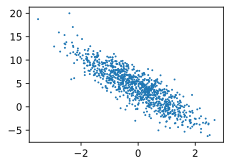

In [18]:
def use_svg_display():
    #矢量图显示
    display.set_matplotlib_formats('svg')

def set_figsize(figsize=(3.5,2.5)):
    use_svg_display()
    # 设置图的尺寸
    plt.rcParams['figure.figsize']=figsize

set_figsize()
plt.scatter(features[:, 1].numpy(), labels.numpy(), 1);


##  读取数据
在训练模型的时候，我们需要遍历数据集并不断读取小批量数据样本。这里我们定义一个函数：它每次返回batch_size（批量大小）个随机样本的特征和标签。

In [20]:
# 本函数已保存在d2lzh包中方便以后使用
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    random.shuffle(indices)  # 样本的读取顺序是随机的
    for i in range(0, num_examples, batch_size):
        j = torch.LongTensor(indices[i: min(i + batch_size, num_examples)]) # 最后一次可能不足一个batch
        #这句话的意思是选择从i到i+batchsize大小的slice，如果到了最后，就选择i到num_examples的切片
        yield  features.index_select(0, j), labels.index_select(0, j)   #选择切片返回，同时程序停止


In [21]:
batch_size=10

for X,y in data_iter(batch_size, features, labels):
    print(X,y)
    break

tensor([[-0.4059, -2.3742],
        [ 0.2185,  1.3295],
        [-1.0632, -0.5064],
        [ 0.0959,  0.3856],
        [ 0.6608,  0.9105],
        [ 0.6675, -0.3632],
        [ 1.6629,  0.7337],
        [-0.6700, -1.9035],
        [ 0.2522,  0.7506],
        [ 1.4110,  1.3257]]) tensor([11.4540,  0.1018,  3.8033,  3.0911,  2.4297,  6.7689,  5.0310,  9.3146,
         2.1568,  2.5150])


带yield的函数是一个生成器，而不是一个函数了，这个生成器有一个函数就是next函数，next就相当于“下一步”生成哪个数，这一次的next开始的地方是接着上一次的next停止的地方执行的，所以调用next的时候，生成器并不会从foo函数的开始执行，只是接着上一步停止的地方开始，然后遇到yield后，return出要生成的数，此步就结束。

执行到yield的时候，程序会暂停，并且返回后面的值，就停在那里了！